# Constructing a rectangular version of image

This notebook will show you how to use `construct_rphi_image` to reconstruct an image from polar to Cartesian coordinates.

This will be done through an application: filling in gapped regions of a sample whose symmetry is known.


In this case, the sample has 10 fold symmetry.

In [1]:
# imports
import matplotlib.pyplot as plt
import numpy as np
from skbeam.core.image import construct_rphi_avg_image

%matplotlib inline

## First we generate the image

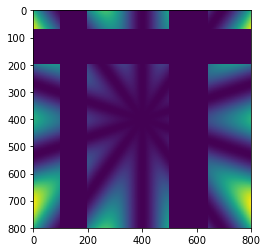

In [2]:
# first generate some random scattering pattern
# There are missing regions
from skbeam.core.utils import angle_grid, radial_grid
shape = 800,800
x0,y0 = 401, 401
ANGLES = angle_grid((y0, x0), shape)
RADII = radial_grid((y0, x0), shape)
img = np.cos(ANGLES*5)**2*RADII**2

mask = np.ones_like((ANGLES))
mask[100:200] = 0
mask[:,100:200] = 0
mask[:,500:643] = 0
mask[70:130] = 0

img*=mask

plt.figure(0);plt.clf();
plt.imshow(mask*img)

## 2. Next re-partition image into a polar grid

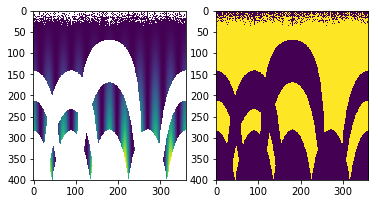

In [3]:
# reconstruct this into a polar grid
from skbeam.core.accumulators.binned_statistic import RPhiBinnedStatistic

rphibinstat = RPhiBinnedStatistic(shape, bins=(400,360), mask=mask, origin=(y0,x0))
rphi_img = rphibinstat(img)
# create mask from np.nans since RPhiBinnedStatistic fills masked regions with np.nans
rphimask = np.ones_like(rphi_img)
rphimask[np.where(np.isnan(rphi_img))] = 0

#plotting partition and mask
plt.figure(2);plt.clf();
plt.subplot(1,2,1)
plt.imshow(rphi_img)
plt.subplot(1,2,2)
plt.imshow(rphimask)

## Now regenerate the image to test construct_rphi_image

In [4]:
# get angles and radii from (q, phi) polar coordinate system
angles = rphibinstat.bin_centers[1]
radii = rphibinstat.bin_centers[0]

# reproject
Zproj = construct_rphi_avg_image(radii, angles, rphi_img, shape=(800,800))

### But we know we have 10 fold symmetry, so let's do something more interesting

Let's add the same image but before reconstructing, shift phi by 2pi/10....

In [5]:
sym = int(10)
polar_shape = 500, 360 
origin = x0, y0

def reconstruct_nfold(img, sym, polar_shape, mask=None, origin=None):
    ''' Reconstruct an image assuming a certain symmetry.
    
        Parameters
        ----------
        img : the image
        
        sym : the symmetry of the sample
        
        polar_shape : the shape of the new polar coordinate image
        
        Returns
        -------
        reconstructed_image : the reconstructed  image
    
    '''
    shape = img.shape
    rphibinstat = RPhiBinnedStatistic(shape, bins=polar_shape, mask=mask, origin=origin)
    angles = rphibinstat.bin_centers[1]
    radii = rphibinstat.bin_centers[0]
    rphi_img = rphibinstat(img)
    # create mask from np.nans since RPhiBinnedStatistic fills masked regions with np.nans
    rphimask = np.ones_like(rphi_img)
    rphimask[np.where(np.isnan(rphi_img))] = 0

    reconstructed_image = np.zeros_like(img)
    reconstructed_image_mask = np.zeros_like(img,dtype=int)
    # symmetry
    dphi = 2*np.pi/float(sym)
    for i in range(sym):
        anglesp = angles + dphi*i
        imgtmp = construct_rphi_avg_image(radii, anglesp, rphi_img,
                                          shape=shape, center=origin, mask=rphimask)
        w = np.where(~np.isnan(imgtmp))
        reconstructed_image[w] += imgtmp[w]
        reconstructed_image_mask += (~np.isnan(imgtmp)).astype(int)
    
    # the mask keeps count of included pixels. Average by this amount
    reconstructed_image /= reconstructed_image_mask
    
    return reconstructed_image

reconstructed_image = reconstruct_nfold(img, sym, polar_shape, mask=mask, origin=origin)

/home/lhermitte/anaconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


## Plot the results

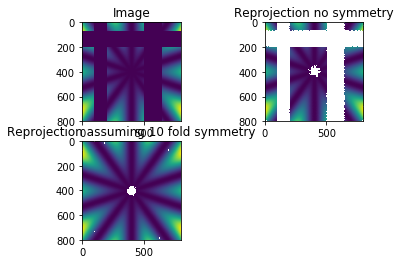

In [6]:
# And finally we have the reconstructed image assuming 5 fold symmetry
plt.figure(4);plt.clf()
plt.subplot(2,2,1).set_aspect("auto", adjustable="box");
plt.title("Image")
plt.imshow(img)
plt.subplot(2,2,2).set_aspect("equal")
plt.title("Reprojection no symmetry")
plt.imshow(Zproj)
plt.subplot(2,2,3).set_aspect("auto", adjustable="box")
plt.title("Reprojection assuming 10 fold symmetry")
plt.imshow(reconstructed_image)